In [1]:
import numpy as np
import sklearn
import pickle
from sklearn.ensemble import RandomForestClassifier
from preprocess import *
from sklearn.preprocessing import MinMaxScaler    
from sklearn.metrics import accuracy_score

# 스켈레톤이 아주 stochastic하기 때문에 5장 중 median으로 smoothing

In [2]:
base_dir = "/home/hoseung/Work/data/BBS/"

action = 1
nframe = 8
frame_skip = 20
feature_ready=False
cam = "e"

In [3]:
### BBS data set
main_list = f"whoismain/whoismain_{cam}_txt/main_list_{cam}_{action}.txt"
npy_list = merge_main_npy(base_dir+main_list, prefix=base_dir + f"npy_{cam}/")

scene = np.load(npy_list[0]['npy'])
data = []
label=[]

for i, fn_npy in enumerate(npy_list):
    if fn_npy['main'] in [0,1]:
        try:
        #if True:
            scene = np.load(fn_npy['npy'])
            for j in range(frame_skip):
                sub = smoothed_frame_N(scene, nframe=nframe, shift=j)

                # feature 기록
                rav_sub = ravel_rec(sub)
                data.append(rav_sub)
                label.append(fn_npy['score'])

        except:
            print("Main person was guessed, but not actually detected... ", fn_npy['npy'])


features = [ff for i in range(nframe) for ff in sub.dtype.names if ff not in "frame" ]
features = np.array(features)

data = np.stack(data)
label = np.array(label)
print(action, data.shape)

1 (8400, 240)


# Test data

In [ ]:
from glob import glob

testdata_dir = "/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/"

score = "*" # 2 or 4

fns = glob(testdata_dir + f"{cam}_*_{action}_{score}_skeleton.pickle")

test_raw = [pickle.load(open(fn, "rb")) for fn in fns]

fns

## preprocess: 원래는 QThreadObj.select_sk*() 함수 안에서 돌아가는 부분

In [4]:
from bbsQt.model import kinect_utils as ku 
from bbsQt.model import rec_utils as ru

In [19]:
skarr = test_raw[0]

sub = ru.smoothed_frame_N(skarr, 
                        nframe=nframe, 
                        shift=1)
new_sks = ru.ravel_rec(sub)[np.newaxis, :]
skeleton = new_sks[0]

# 두 종류의 데이터셋을 잘~ 표준화하기 

## Depth 카메라의 전체 영역은 512 x 512 픽셀이고, 실제로는 512 내부의 둥근 원형의 영역, 반지름이 대략 200 정도? 

### -> 중심은 (256,256)으로 가정

In [11]:
import matplotlib.pyplot as plt 
#import seaborn as sns; sns.set()

In [12]:
data.shape

(8400, 240)

In [13]:
# x, y 좌표 분리
xdata = data[:,::2]
ydata = data[:,1::2]

In [20]:
xsk = skeleton[::2]
ysk = skeleton[1::2]

In [21]:
def plot_band(data, frac_lower = 0.2, frac_upper = 0.8):
    lower, upper = np.quantile(data, [frac_lower, frac_upper], axis=0)
    
    x = np.arange(len(lower))

    plt.fill_between(x, lower, upper, color='b', alpha=0.2)
    represent = np.median(data, axis=0)
    plt.plot(x, represent)    

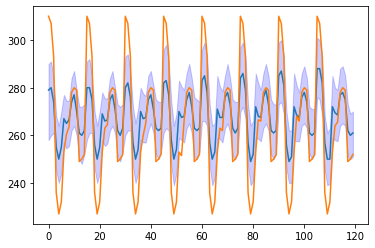

In [22]:
plot_band(xdata)
plt.plot(xsk)
plt.show()

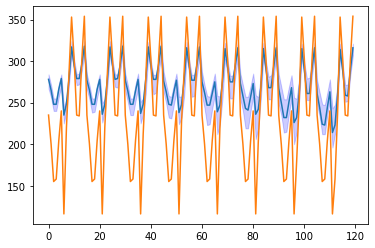

In [23]:
plot_band(ydata, 0.05, 0.95)
plt.plot(ysk)
plt.show()

1. 특정 뼈 길이로 normalize
2. 중심 위치 이동 

# joint 이름

In [8]:
from bbsQt.model import BBS_pp_utils as bbpp
# 키 normalize 
## 어깨 - 팔꿈치 / 허벅지 / 종아리 
common_joints = bbpp.COMMON_JOINT

xy_joint_inds = dict([(name,i) for i, name in enumerate([prefix+cj for cj in common_joints for prefix in ["x", "y"]])])

def joint_length(joint, j1:str, j2:str):
    """measure lentgh of a joint from j1 to j2"""
    x1 = joint[xy_joint_inds["x"+j1]]
    x2 = joint[xy_joint_inds["x"+j2]]
    y1 = joint[xy_joint_inds["y"+j1]]
    y2 = joint[xy_joint_inds["y"+j2]]
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)
    

## Centering

In [9]:
# To do: 0이 아닌 점들에 대해서만.. 
# 좌-우 중 하나만 0이면 반대편도 같이 제외
def shift_to_zero(skeleton, nframe=2, njoints=30):
    early_frame_x = skeleton[:nframe*njoints:2]
    early_frame_y = skeleton[1:nframe*njoints:2]

    ix_nz = np.nonzero(early_frame_x)
    iy_nz = np.nonzero(early_frame_y)

    mean_x = np.mean(early_frame_x[ix_nz])
    mean_y = np.mean(early_frame_y[iy_nz])
    
    skeleton[::2] -= mean_x 
    skeleton[1::2] -= mean_y 
    return skeleton

In [39]:
# Shift to around (256,256)
skeleton = shift_to_zero(skeleton)

In [40]:
for joint in data:
    joint = shift_to_zero(joint)

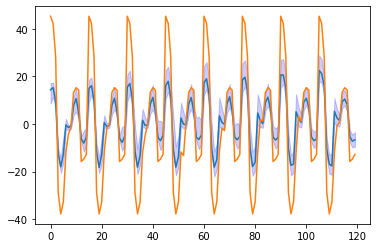

In [41]:
plot_band(xdata)
plt.plot(skeleton[::2])
plt.show()

### Skeleton은 2D 모양임 (tensor input이어서)

In [44]:
joint_length(skeleton[30:60], 'l_elbow', 'l_shoulder')

47.12748667179271

In [45]:
joint_length(skeleton[:30], 'r_elbow', 'r_shoulder')

46.872166581031856

In [46]:
print(joint_length(skeleton[:30], 'l_hip', 'l_knee'),
      joint_length(skeleton[:30], 'r_hip', 'r_knee'))

68.00735254367721 67.00746227100382


In [47]:
print(joint_length(skeleton[:30], 'l_foot', 'l_knee'),
      joint_length(skeleton[:30], 'r_foot', 'r_knee'))

50.03998401278722 53.037722424704484


In [13]:
def arms_and_legs(skeleton, topk=2):
    """
    get representative length of arms and legs
    """
    lls = []
    rls = []
    las = []
    ras = []
    for sk in skeleton.reshape(-1, 30):
        lls.append(joint_length(sk, 'l_hip', 'l_knee'))
        rls.append(joint_length(sk, 'r_hip', 'r_knee'))
        las.append(joint_length(sk, 'l_elbow', 'l_shoulder'))
        ras.append(joint_length(sk, 'r_elbow', 'r_shoulder')) 

    out = []    
    for arr in (lls, rls, las, ras):
        out.append(arr[np.argsort(arr)[-topk]])
    return out


PAIRS = {'larm':('l_elbow', 'l_shoulder'),
         'rarm':('r_elbow', 'r_shoulder'), 
         'lleg':('l_hip', 'l_knee'),
         'rleg':('r_hip', 'r_knee'),
         'body':('neck', 'pelvis')}

def measure_lengths(skeleton, topk=2):
    """
    get representative lengths of joints
    """
    
    out = []
    for pair in PAIRS:
        lengths = []
        for sk in skeleton.reshape(-1, 30):
            lengths.append(joint_length(sk, *PAIRS[pair]))
            
        out.append((pair,lengths[np.argsort(lengths)[-topk]]))
            
    return dict(out)

In [49]:
armlegarr = np.zeros(len(data), dtype=[(pp, float) for pp in PAIRS])
for i, dd in enumerate(data):
    body = measure_lengths(dd)
    for pp in PAIRS:
        armlegarr[i][pp] = body[pp]#

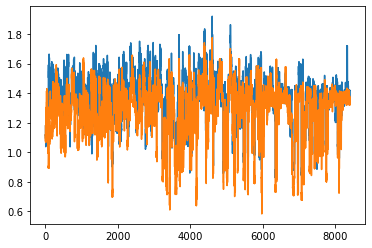

In [50]:
plt.plot(armlegarr['lleg']/armlegarr['larm'])
#plt.plot()
plt.plot(armlegarr['rleg']/armlegarr['rarm'])
#plt.plot()
plt.show()

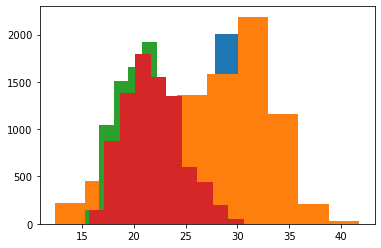

In [51]:
plt.hist(armlegarr['lleg'])
plt.hist(armlegarr['rleg'])
plt.hist(armlegarr['larm'])
plt.hist(armlegarr['rarm'])
plt.show()

# Normalize by body length

In [14]:
for joint in data:
    joint = shift_to_zero(joint)
    
for dd in data:
    body = measure_lengths(dd)
    dd /= body['body'] 
#    return skeleton

In [15]:
plt.plot(data[:,4])

NameError: name 'plt' is not defined

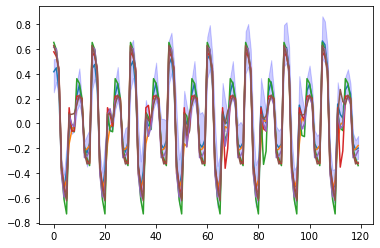

In [55]:
plot_band(xdata)

for skarr in test_raw:
    sub = ru.smoothed_frame_N(skarr, 
                            nframe=nframe, 
                            shift=1)
    new_sks = ru.ravel_rec(sub)[np.newaxis, :]

    this_sk = new_sks[0]
    this_sk = shift_to_zero(this_sk)
    body = measure_lengths(this_sk)
    this_sk /= body['body']

    plt.plot(this_sk[::2])
plt.show()

# Training RF model
## BBS 데이터셋으로 훈련하지만 새로 찍은 스켈레톤 결과도 잘 나와야함. 

In [10]:
small = True
if small:
    ntrees = 20
    max_depth = 6
else:
    ntrees = 100
    max_depth = 7

In [35]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(data, 
                                                                            label, 
                                                                            test_size=0.7, 
                                                                            stratify=label)

scaler = MinMaxScaler()
# Use whole data to impose stricter boundary condition
X_total = np.concatenate((X_test, X_train))
scaler.fit(X_total)
pickle.dump(scaler, open(f"scaler_{action}_{cam}.pickle", 'wb'))

X_train_normed = scaler.transform(X_train)
X_test_normed = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=ntrees, max_depth=max_depth)
model.fit(X_train_normed, Y_train)

pred = model.predict(X_test_normed)
print("정확도 :{0:.3f}".format(accuracy_score(Y_test, pred)))

pickle.dump(model, open(f"trained_model_{action}_{cam}.pickle", "wb"))

data_to_save = {"train_x":X_train_normed, 
                 "train_y":Y_train,
                 'valid_x':X_test_normed,
                 'valid_y':Y_test}
pickle.dump(data_to_save, open(f"BBS_dataset_{action}_{cam}.pickle", "wb"))

정확도 :0.874


In [36]:
pred

array([4, 1, 3, ..., 0, 1, 0])

# Test with new data

In [40]:
from glob import glob

testdata_dir = "/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/"

score = "*" # 2 or 4

fns = glob(testdata_dir + f"{cam}_*_{action}_{score}_skeleton.pickle")

test_raw = [pickle.load(open(fn, "rb")) for fn in fns]

print("# test skeletons :", len(fns))

# test skeletons : 19


이렇게 많다고..??

In [41]:
fns

['/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16141247_1_4_skeleton.pickle',
 '/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16174141_1_4_skeleton.pickle',
 '/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16141349_1_3_skeleton.pickle',
 '/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16143156_1_1_skeleton.pickle',
 '/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16174026_1_4_skeleton.pickle',
 '/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16175033_1_4_skeleton.pickle',
 '/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16174653_1_4_skeleton.pickle',
 '/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16143317_1_0_skeleton.pickle',
 '/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16141218_1_4_skeleton.pickle',
 '/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16141433_1_2_skeleton.pickle',
 '/home/ho

1. x_test로 model 제대로 돌아가는지 먼저 확인
2. data의 일부에 대해서 표준화 제대로 되는지 확인
3. 새로 찍은 스켈레톤에 대해서 예측이 정확한지 확인 

In [ ]:
xx = data[:100]

model.predict()

In [91]:
import pickle

preds = []
for fn in fns:
    skarr = pickle.load(open(fn, "rb"))
    

In [42]:
### BBS data set
main_list = f"whoismain/whoismain_{cam}_txt/main_list_{cam}_{action}.txt"
npy_list = merge_main_npy(base_dir+main_list, prefix=base_dir + f"npy_{cam}/")

preds=[]
#for i, fn in enumerate(npy_list[::30]):
#    if fn['main'] in [0,1]:
#        try:
#            skarr = np.load(fn['npy'])
#        except:
#            continue

for fn in fns:
    skarr = pickle.load(open(fn, "rb"))

    # sampling
    sub = ru.smoothed_frame_N(skarr, 
                            nframe=nframe, 
                            shift=0)
    new_sks = ru.ravel_rec(sub)[np.newaxis, :]    
    
    # standardization
    skeleton = shift_to_zero(new_sks[0])    
    body = measure_lengths(skeleton)
    skeleton /= body['body'] 
    
    # scaling
    sk_normed = scaler.transform(skeleton[np.newaxis, :])
    
    preds.append(model.predict(sk_normed))
    print(fn)

/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16141247_1_4_skeleton.pickle
/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16174141_1_4_skeleton.pickle
/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16141349_1_3_skeleton.pickle
/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16143156_1_1_skeleton.pickle
/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16174026_1_4_skeleton.pickle
/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16175033_1_4_skeleton.pickle
/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16174653_1_4_skeleton.pickle
/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16143317_1_0_skeleton.pickle
/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16141218_1_4_skeleton.pickle
/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_data/TestDataset/e_16141433_1_2_skeleton.pickle
/home/hoseung/Dropbox/DeepInsight/2021ETRI/BBS_dat

In [43]:
preds

[array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([1]),
 array([2]),
 array([3]),
 array([1]),
 array([3]),
 array([3]),
 array([2]),
 array([3]),
 array([2]),
 array([3])]

너무 틀리진 않은데, 동작이 제대로 됐던건지 잘 모르겠음... 